DEPENDENCIES

In [8]:
import pandas as pd
import os
import pickle
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, Conv2D, MaxPooling2D, Reshape, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from random import randrange
from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from datetime import datetime
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import csv


# FUNCTIONS

In [16]:
def extract_data(file_dir):
    with open(file_dir) as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter="\t")
        event_list = []

        # Calculate the number of rows to skip to get to the markers data
        number_of_rows_to_skip = 0

        # Record all events first before skipping these lines
        print("Retrieving events...")
        for line in tsvreader:
            # If the line starts with 'EVENT', append the event details to the event list
            if line[0] == 'EVENT':
                event_list.append(line[1])
                event_list.append(line[2])
            
            # Once the 'Frame' line is found, stop collecting events and break the loop
            if line[0] == "Frame":
                break
            
            # Count of rows to skip
            number_of_rows_to_skip += 1

        print("Retrieving trajectory data...")
        # Read the trajectory data from the TSV file, skipping the identified number of rows
        data = pd.read_csv(file_dir, delimiter="\t", skiprows=number_of_rows_to_skip)

        # Exclude frames before the first phase is identified
        data = data.iloc[data[data["Frame"] == int(event_list[1])].index[0]:, :]

        # Initialize a list to store the label for each frame
        event_frames = []

        # Loop through the event list to assign labels to the corresponding frames
        for i in range(1, int(len(event_list)) - 1, 2):
            # For each phase, append the corresponding label to the event_frames list
            for j in range(abs(int(event_list[i]) - int(event_list[i + 2]))):
                event_frames.append(str(event_list[i - 1]))
            
            # If it's the last phase, append the label for the remaining frames
            if i == int(len(event_list)) - 3:
                for k in range(len(data) - len(event_frames)):
                    event_frames.append(str(event_list[i - 1]))

        # Insert the event_frames list as a new column named "labels" in the data DataFrame
        data.insert(data.shape[1], "labels", event_frames)
        
        # Replace specific values in the "labels" column
        data = data.replace({"labels": {"I": "B", "J": "C", "H": "F"}})


    print("Retrieving standard marker set...")
    standard_features =  ["labels", "Frame", "LFCC", "LFMT2", "LFAL", "LSK1", "LFLE", "LTH1", "LASIS", "LPSIS", "RPSIS", "RASIS", "RTH1", "RFLE", "RSK1", "RFAL", "RFMT2", "RFCC"]
    # Extract the columns that contain any of the standard feature names
    extracted_columns = [col for col in data.columns if any(feature in col for feature in standard_features)]

    # Create a new DataFrame with the extracted columns
    cleaned_data = data[extracted_columns].reset_index(drop=True)

    # Extract the 'labels' and 'Frame' columns from the data
    label = cleaned_data["labels"]

    # Remove 'labels' and 'Frame' columns from the data
    cleaned_data = cleaned_data.loc[:, ~cleaned_data.columns.isin(['labels', 'Frame'])]
    

    return cleaned_data, label




In [17]:
def standardize_data(data):
    print("Calculating pelvis midpt...")
    # Calculate the initial midpoint (origin) of the pelvis based on the first frame's PSIS coordinates directly from data
    midpt_ori = [
        (data["LPSIS X"].iloc[0] + data["RPSIS X"].iloc[0]) / 2,
        (data["LPSIS Y"].iloc[0] + data["RPSIS Y"].iloc[0]) / 2
    ]

    print("Translating to local reference using pelvis midpt...")
    # Loop through each column in the data
    for i in data.columns:
        # If the column name ends with "X", subtract the x-coordinate of the pelvis midpoint from its values
        if i[-1] == "X":
            data[i] = data[i] - midpt_ori[0]
        # If the column name ends with "Y", subtract the y-coordinate of the pelvis midpoint from its values
        if i[-1] == "Y":
            data[i] = data[i] - midpt_ori[1]

    print("Scaling data...")
    # Store the original column names
    original_header = data.columns

    # Standardize the data
    X_scaled = MinMaxScaler().fit_transform(data)

    # Convert the standardized data back to a DataFrame with the original column names
    X_scaled = pd.DataFrame(X_scaled, columns=original_header)
    
    # Return the updated data with translated trajectories
    return X_scaled

In [18]:
def PCA_transformation(data, pelvis_before_pca, pelvis_after_pca):
    print("Calculating pelvis midpt...")
    # Calculate the midpoint of the pelvis for each frame
    pelvis_midpt_before_pca = pd.DataFrame()
    pelvis_midpt_before_pca["X"] = (data["LPSIS X"] + data["RPSIS X"]) / 2
    pelvis_midpt_before_pca["Y"] = (data["LPSIS Y"] + data["RPSIS Y"]) / 2

    # Initialize and fit PCA on the pelvis midpoints
    pca = PCA(n_components=2)
    pca.fit(pelvis_midpt_before_pca)

    # Create a list of unique markers by removing the coordinate suffixes (" X", " Y", " Z")
    marker_list = set([i.replace(" X", "").replace(" Y", "").replace(" Z", "") for i in data.columns])

    # Initialize an empty DataFrame to store the PCA-transformed coordinates
    X_pca = pd.DataFrame()

    print("Translating data along eigenvector...")
    # Loop through each marker to apply PCA transformation on its coordinates
    for marker in marker_list:
        # Extract the Z-axis values for the marker
        z_axis = np.array(data[marker + " Z"])
        
        # Create a DataFrame with the X and Y coordinates of the marker
        coordinates = pd.DataFrame({"X": data[marker + " X"], "Y": data[marker + " Y"]})
        
        # Check for NaN values in the coordinates and print a message if any are found
        if coordinates.isna().any().any():
            print(f"NaN values found in coordinates for marker: {marker}")
            print(coordinates.isna().sum())
        
        # Transform the coordinates using PCA
        pca_coordinates = pca.transform(coordinates)
        
        # Store the PCA-transformed coordinates and the original Z-axis values in the X_pca DataFrame
        X_pca[marker + " X"] = pca_coordinates[:, 0]
        X_pca[marker + " Y"] = pca_coordinates[:, 1]
        X_pca[marker + " Z"] = z_axis

    # Convert the X_pca DataFrame back to a DataFrame
    X_pca = pd.DataFrame(X_pca)

    # # Print the explained variance ratio and PCA components
    # print(pca.explained_variance_ratio_)
    # print(pca.components_)

    print("Collating data for visualisation before PCA transformation...")
    # Check if pelvis_before_pca is empty
    if pelvis_before_pca.empty:
        # If empty, assign pelvis_midpt_before_pca to pelvis_before_pca
        pelvis_before_pca = pelvis_midpt_before_pca
    else:
        # If not empty, concatenate pelvis_midpt_before_pca to pelvis_before_pca along rows
        pelvis_before_pca = pd.concat([pelvis_before_pca, pelvis_midpt_before_pca], axis=0)

    print("Collating data for visualisation after PCA transformation...")
    # Create a new DataFrame to store the PCA-transformed pelvis midpoint
    pelvis_pca = pd.DataFrame()

    # Calculate the PCA-transformed pelvis midpoint by averaging the X and Y coordinates of LPSIS and RPSIS
    pelvis_pca["X"] = (X_pca["LPSIS X"] + X_pca["RPSIS X"]) / 2
    pelvis_pca["Y"] = (X_pca["LPSIS Y"] + X_pca["RPSIS Y"]) / 2

    # Check if pelvis_after_pca is empty
    if pelvis_after_pca.empty:
        # If empty, assign pelvis_pca to pelvis_after_pca
        pelvis_after_pca = pelvis_pca
    else:
        # If not empty, concatenate pelvis_pca to pelvis_after_pca along rows
        pelvis_after_pca = pd.concat([pelvis_after_pca, pelvis_pca], axis=0)

    return X_pca, pelvis_before_pca, pelvis_after_pca

In [19]:
def create_moving_window(data, label):
    # Store the original feature headers from the data
    feature_header = data.columns
    
    # Create new feature headers for the moving window, adding a suffix for each of the 3 frames
    feature_header = ['{0}_{1}'.format(i, j) for j in range(3) for i in feature_header]

    # Add 'Frame' and 'labels' columns back to the feature headers
    feature_header.append("labels")

    # Initialize an empty dataframe to store the moving window data
    moving_window_data = pd.DataFrame(columns=feature_header)

    # Initialize frame counter
    frame = -1
    
    # Loop through the data, creating a moving window of size 3
    for i in tqdm(range(len(data) - 4), desc="Looping through the data..."):
        frame += 1
        # Check if the labels of the current frame and the next two frames are the same
        if np.array(label[i]) == np.array(label[i + 1]) == np.array(label[i + 2]):
            current_label = label[i]  # Store the current label
            current_moving_frame = []  # Initialize a list to store the current moving frame data
            
            # Extend the current moving frame with the data of the current frame and the next two frames
            for k in range(3):
                current_moving_frame.extend(np.array(data.loc[i + k, :].values))

            # Append the current label to the moving frame data
            current_moving_frame.append(current_label)
            
            # Add the current moving frame data to the moving window DataFrame
            moving_window_data = pd.concat(
                [moving_window_data, pd.DataFrame([current_moving_frame], columns=feature_header)],
                ignore_index=True
            )

    return moving_window_data

In [20]:
dir = r"C:\Users\User\Documents\Data\train"       # change path
final_data = pd.DataFrame()
directions_before_pca = pd.DataFrame()
directions_after_pca = pd.DataFrame()
subjectNumber = 0
for files in os.listdir(dir):
    if files.endswith(".tsv"):
        print("___Working on file", files + "___\n")

        print("EXTRACTING DATA")
        subjectNumber += 1
        data, label = extract_data(os.path.join(dir, files))
        print("Extraction complete.\n")

        # this part not to be included for other people
        # data.drop(columns=['RTH2 X', 'RTH2 Y',  'RTH2 Z', 'RTH3 X', 'RTH3 Y', 'RTH3 Z', 'RTH4 X', 'RTH4 Y',  'RTH4 Z', 'LTH2 X', 'LTH2 Y',  'LTH2 Z', 'LTH3 X', 'LTH3 Y',  'LTH3 Z', 'LTH4 X', 'LTH4 Y',  'LTH4 Z'])

        print("STANDARDISING DATA")
        standardised_data = standardize_data(data)
        print("Standardisation complete.\n")

        print("PCA TRANSFORMATION")
        X_pca, directions_before_pca, directions_after_pca = PCA_transformation(standardised_data, directions_before_pca, directions_after_pca)
        print("PCA Transformation complete.\n")

        print("CREATE MOVING WINDOW")
        moving_window_data = create_moving_window(X_pca, label)
        print("Creation of Moving Window complete.\n")


        print("___Working ended for", files + "___\n")

        print("Consolidating final dataset...")
        if final_data.empty:
            final_data = moving_window_data
        else:
            final_data = pd.concat([final_data, moving_window_data], axis = 0)
        print("Consolidation complete...\n")
        
# final dataset
final_data = final_data.reset_index()
final_data = final_data.drop(columns = ["index"])

print("____FINAL DATASET OBTAINED____")

        

___Working on file SN001_0013_10m_04_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/518 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 518/518 [00:01<00:00, 296.57it/s]


Creation of Moving Window complete.

___Working ended for SN001_0013_10m_04_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN002_0029_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/594 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 594/594 [00:01<00:00, 352.28it/s]


Creation of Moving Window complete.

___Working ended for SN002_0029_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN003_0010_10m_04_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/617 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 617/617 [00:01<00:00, 330.33it/s]


Creation of Moving Window complete.

___Working ended for SN003_0010_10m_04_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN011_0035_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/654 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 654/654 [00:01<00:00, 365.73it/s]


Creation of Moving Window complete.

___Working ended for SN011_0035_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN014_0041_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/713 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 713/713 [00:02<00:00, 352.01it/s]


Creation of Moving Window complete.

___Working ended for SN014_0041_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN016_0055_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/540 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 540/540 [00:01<00:00, 359.65it/s]


Creation of Moving Window complete.

___Working ended for SN016_0055_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN018_0049_10m_01_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/699 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 699/699 [00:02<00:00, 334.73it/s]


Creation of Moving Window complete.

___Working ended for SN018_0049_10m_01_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN027_0024_10m_03_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/679 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 679/679 [00:02<00:00, 331.40it/s]


Creation of Moving Window complete.

___Working ended for SN027_0024_10m_03_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN050_0013_10m_01_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/680 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 680/680 [00:01<00:00, 347.67it/s]


Creation of Moving Window complete.

___Working ended for SN050_0013_10m_01_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN086_0006_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/543 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 543/543 [00:01<00:00, 336.79it/s]


Creation of Moving Window complete.

___Working ended for SN086_0006_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN087_0017_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/572 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 572/572 [00:01<00:00, 344.94it/s]


Creation of Moving Window complete.

___Working ended for SN087_0017_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN088_0014_10m_02_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/505 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 505/505 [00:01<00:00, 372.30it/s]


Creation of Moving Window complete.

___Working ended for SN088_0014_10m_02_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN090_0014_10m_06_done.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/493 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 493/493 [00:01<00:00, 365.08it/s]


Creation of Moving Window complete.

___Working ended for SN090_0014_10m_06_done.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN202_0009_10m_02.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/540 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 540/540 [00:01<00:00, 404.14it/s]


Creation of Moving Window complete.

___Working ended for SN202_0009_10m_02.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN206_0026_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/635 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 635/635 [00:01<00:00, 356.54it/s]


Creation of Moving Window complete.

___Working ended for SN206_0026_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN210_0033_10m_07.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/576 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 576/576 [00:02<00:00, 282.83it/s]


Creation of Moving Window complete.

___Working ended for SN210_0033_10m_07.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN213_0010_10m_02.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/592 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 592/592 [00:01<00:00, 359.42it/s]


Creation of Moving Window complete.

___Working ended for SN213_0010_10m_02.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN217_0026_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/430 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 430/430 [00:01<00:00, 330.52it/s]


Creation of Moving Window complete.

___Working ended for SN217_0026_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN220_0015_10m_04.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/671 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 671/671 [00:02<00:00, 321.88it/s]


Creation of Moving Window complete.

___Working ended for SN220_0015_10m_04.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN244_0030_10m_02.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/664 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 664/664 [00:01<00:00, 377.20it/s]


Creation of Moving Window complete.

___Working ended for SN244_0030_10m_02.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN246_0017_10m_05.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/650 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 650/650 [00:02<00:00, 261.20it/s]


Creation of Moving Window complete.

___Working ended for SN246_0017_10m_05.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN260_0036_10m_02.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/519 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 519/519 [00:01<00:00, 403.84it/s]


Creation of Moving Window complete.

___Working ended for SN260_0036_10m_02.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN308_0025_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/706 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 706/706 [00:01<00:00, 360.96it/s]


Creation of Moving Window complete.

___Working ended for SN308_0025_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN373_0008_10M_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/578 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 578/578 [00:01<00:00, 334.75it/s]


Creation of Moving Window complete.

___Working ended for SN373_0008_10M_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN376_0013_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/564 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 564/564 [00:01<00:00, 360.08it/s]

Creation of Moving Window complete.

___Working ended for SN376_0013_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

____FINAL DATASET OBTAINED____


In [21]:
dir = r"C:\Users\User\Documents\Data\test"      # change path
final_test_data = pd.DataFrame()
directions_before_pca_test = pd.DataFrame()
directions_after_pca_test = pd.DataFrame()
subjectNumber = 0
for files in os.listdir(dir):
    if files.endswith(".tsv"):
        print("___Working on file", files + "___\n")

        print("EXTRACTING DATA")
        subjectNumber += 1
        data, label = extract_data(os.path.join(dir, files))
        print("Extraction complete.\n")

        # this part not to be included for other people
        # data.drop(columns=['RTH2 X', 'RTH2 Y',  'RTH2 Z', 'RTH3 X', 'RTH3 Y', 'RTH3 Z', 'RTH4 X', 'RTH4 Y',  'RTH4 Z', 'LTH2 X', 'LTH2 Y',  'LTH2 Z', 'LTH3 X', 'LTH3 Y',  'LTH3 Z', 'LTH4 X', 'LTH4 Y',  'LTH4 Z'])

        print("STANDARDISING DATA")
        standardised_data = standardize_data(data)
        print("Standardisation complete.\n")

        print("PCA TRANSFORMATION")
        X_pca, directions_before_pca_test, directions_after_pca_test = PCA_transformation(standardised_data, directions_before_pca_test, directions_after_pca_test)
        print("PCA Transformation complete.\n")

        print("CREATE MOVING WINDOW")
        moving_window_data = create_moving_window(X_pca, label)
        print("Creation of Moving Window complete.\n")


        print("___Working ended for", files + "___\n")

        print("Consolidating final dataset...")
        if final_test_data.empty:
            final_test_data = moving_window_data
        else:
            final_test_data = pd.concat([final_test_data, moving_window_data], axis = 0)
        print("Consolidation complete...\n")
        
# final dataset
final_test_data = final_test_data.reset_index()
final_test_data = final_test_data.drop(columns = ["index"])

print("____FINAL TEST DATASET OBTAINED____")

        

___Working on file SN201_0008_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/782 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 782/782 [00:02<00:00, 353.42it/s]


Creation of Moving Window complete.

___Working ended for SN201_0008_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN205_0017_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/724 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 724/724 [00:02<00:00, 271.80it/s]


Creation of Moving Window complete.

___Working ended for SN205_0017_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN207_0007_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/671 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 671/671 [00:01<00:00, 382.34it/s]


Creation of Moving Window complete.

___Working ended for SN207_0007_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN208_0005_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/737 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 737/737 [00:02<00:00, 351.34it/s]


Creation of Moving Window complete.

___Working ended for SN208_0005_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN209_0011_10m_01.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/529 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 529/529 [00:01<00:00, 371.72it/s]


Creation of Moving Window complete.

___Working ended for SN209_0011_10m_01.tsv___

Consolidating final dataset...
Consolidation complete...

___Working on file SN211_0027_10m_02.tsv___

EXTRACTING DATA
Retrieving events...
Retrieving trajectory data...
Retrieving standard marker set...
Extraction complete.

STANDARDISING DATA
Calculating pelvis midpt...
Translating to local reference using pelvis midpt...
Scaling data...
Standardisation complete.

PCA TRANSFORMATION
Calculating pelvis midpt...
Translating data along eigenvector...
Collating data for visualisation before PCA transformation...
Collating data for visualisation after PCA transformation...
PCA Transformation complete.

CREATE MOVING WINDOW


Looping through the data...:   0%|          | 0/562 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_56476\753599103.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moving_window_data = pd.concat(
Looping through the data...: 100%|██████████| 562/562 [00:01<00:00, 350.54it/s]

Creation of Moving Window complete.

___Working ended for SN211_0027_10m_02.tsv___

Consolidating final dataset...
Consolidation complete...

____FINAL TEST DATASET OBTAINED____


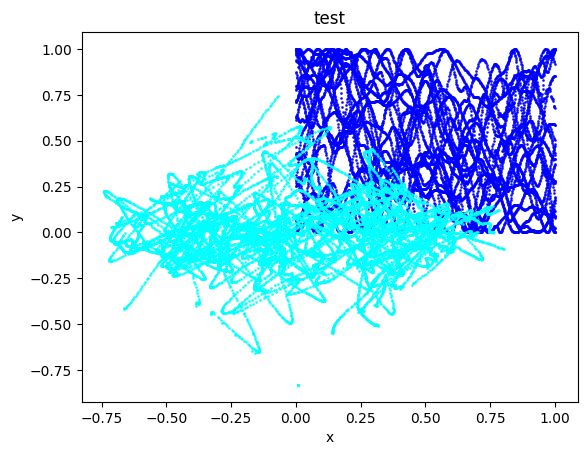

In [22]:
fig=plt.figure()
graph = fig.add_subplot(111)
# graph.scatter(pelvis_midpt[:, 0], pelvis_midpt[:, 1], alpha=0.8, color = 'red', s = 1)
graph.scatter(np.array(directions_before_pca)[:, 0], np.array(directions_before_pca)[:,1], alpha=0.8, color = 'blue', s = 1)
graph.scatter(np.array(directions_after_pca)[:, 0], np.array(directions_after_pca)[:, 1], alpha=0.8, color = 'cyan', s = 1)
# graph.scatter(back_pelvis_XY_coordinates["LPSIS X"], back_pelvis_XY_coordinates["LPSIS Y"], alpha=0.8, color = 'blue', s = 1)
# graph.scatter(back_pelvis_XY_coordinates["RPSIS X"], back_pelvis_XY_coordinates["RPSIS Y"], alpha=0.8, color = 'red', s = 1)
# graph.scatter(midpt["X"], midpt["Y"], alpha=0.8, color = 'cyan', s = 1)
# plot_graph(JA_mean, graph)
graph.set_xlabel('x')
graph.set_ylabel('y')
graph.set_title('test')
# graph.axis('equal')
plt.show()

In [23]:
y_train = final_data["labels"]
X_train = final_data.drop(columns = ["labels"])

y_test = final_test_data["labels"]
X_test = final_test_data.drop(columns = ["labels"])

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# MODEL: CNN-biLSTM

In [29]:
# List of unique marker_seq (for example)
marker_seq =  ["LFCC", "LFMT2", "LFAL", "LSK1", "LFLE", "LTH1", "LASIS", "LPSIS", "RPSIS", "RASIS", "RTH1", "RFLE", "RSK1", "RFAL", "RFMT2", "RFCC"]
dimensions = ['X', 'Y', 'Z']
frames = ['0', '1', '2']

# Initialize the final 3D array
X_train = np.zeros((len(marker_seq), len(frames), len(dimensions), final_data.shape[0]))

# Process each marker
for marker_idx, marker in enumerate(marker_seq):
    for frame_idx, frame in enumerate(frames):
        for axis_idx, axis in enumerate(dimensions):
            col_name = f"{marker} {axis}_{frame}"
            X_train[marker_idx, frame_idx, axis_idx, :] = final_data[col_name].values

# Transpose the data to match (samples, height, width, channels)
X_train = X_train.transpose(3, 0, 1, 2)
print(X_train.shape)

(13870, 16, 3, 3)


In [30]:
# Initialize the final 3D array
X_test = np.zeros((len(marker_seq), len(frames), len(dimensions), final_test_data.shape[0]))

# Process each marker
for marker_idx, marker in enumerate(marker_seq):
    for frame_idx, frame in enumerate(frames):
        for axis_idx, axis in enumerate(dimensions):
            col_name = f"{marker} {axis}_{frame}"
            X_test[marker_idx, frame_idx, axis_idx, :] = final_test_data[col_name].values

# Transpose the data to match (samples, height, width, channels)
X_test = X_test.transpose(3, 0, 1, 2)
print(X_test.shape)

(3699, 16, 3, 3)


In [41]:
# Define the model
model_cnn_bilstm = Sequential()
# Extract Feature
model_cnn_bilstm.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model_cnn_bilstm.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the feature maps
model_cnn_bilstm.add(Flatten())

# Reshape the flattened output to (batch_size, timesteps, features)
model_cnn_bilstm.add(Reshape((224, 1)))

# Add Bidirectional LSTM layer
model_cnn_bilstm.add(Bidirectional(LSTM(256), input_shape=(224, 1)))

# Add the fully connected layers with dropout
model_cnn_bilstm.add(Dense(78, activation='relu'))
model_cnn_bilstm.add(Dropout(0.2))
model_cnn_bilstm.add(Dense(39, activation='relu'))
model_cnn_bilstm.add(Dropout(0.2))
# Output layer
model_cnn_bilstm.add(Dense(7, activation='softmax'))

# Compile the model
model_cnn_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_cnn_bilstm = model_cnn_bilstm.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])


c:\Users\User\anaconda3\envs\capstone\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\anaconda3\envs\capstone\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 242s 547ms/step - accuracy: 0.3646 - loss: 1.5294 - val_accuracy: 0.8032 - val_loss: 0.5695
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 254s 586ms/step - accuracy: 0.7710 - loss: 0.6080 - val_accuracy: 0.9092 - val_loss: 0.2544
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 259s 596ms/step - accuracy: 0.8711 - loss: 0.3869 - val_accuracy: 0.9316 - val_loss: 0.1957
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 262s 604ms/step - accuracy: 0.9059 - loss: 0.2888 - val_accuracy: 0.9084 - val_loss: 0.2422
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 262s 605ms/step - accuracy: 0.9187 - loss: 0.2590 - val_accuracy: 0.9289 - val_loss: 0.1867
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 263s 605ms/step - accuracy: 0.9222 - loss: 0.2431 - val_accuracy: 0.9311 - val_loss: 0.1839
Epoch 7/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 265s 612ms/step - accuracy: 0.9340 - loss: 0.2077 - val_accuracy: 0.9311 - val_loss: 0.1845
Epoch 8/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 261s 601ms/step - accuracy: 0.9347 -

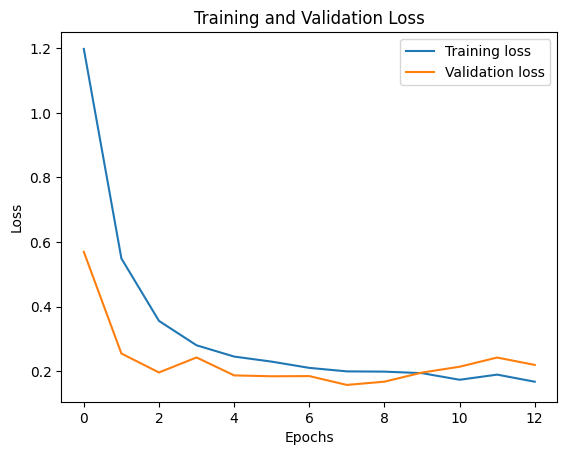

In [42]:
# Plot the training and validation loss
plt.plot(history_cnn_bilstm.history['loss'], label='Training loss')
plt.plot(history_cnn_bilstm.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Predict the labels for the test set
y_pred_encoded_cnn_bilstm = model_cnn_bilstm.predict(X_test)

# Convert the one-hot encoded predictions back to original labels
y_pred_cnn_bilstm = encoder.inverse_transform(y_pred_encoded_cnn_bilstm)

# Generate and print the classification report
report = classification_report(y_test, y_pred_cnn_bilstm, output_dict=True)
print(report)

116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step
{'A': {'precision': 0.9077306733167082, 'recall': 0.9357326478149101, 'f1-score': 0.9215189873417722, 'support': 389.0}, 'B': {'precision': 0.9601029601029601, 'recall': 0.9209876543209876, 'f1-score': 0.9401386263390044, 'support': 810.0}, 'C': {'precision': 0.9436038514442916, 'recall': 0.9648382559774965, 'f1-score': 0.9541029207232267, 'support': 711.0}, 'D': {'precision': 0.9253731343283582, 'recall': 0.9597523219814241, 'f1-score': 0.9422492401215805, 'support': 323.0}, 'E': {'precision': 0.926509186351706, 'recall': 0.8959390862944162, 'f1-score': 0.9109677419354839, 'support': 394.0}, 'F': {'precision': 0.9673202614379085, 'recall': 0.9396825396825397, 'f1-score': 0.9533011272141707, 'support': 630.0}, 'G': {'precision': 0.9377682403433476, 'recall': 0.9886877828054299, 'f1-score': 0.9625550660792952, 'support': 442.0}, 'accuracy': 0.9429575560962422, 'macro avg': {'precision': 0.9383440439036114, 'recall': 0.943660041268172, 'f1-scor

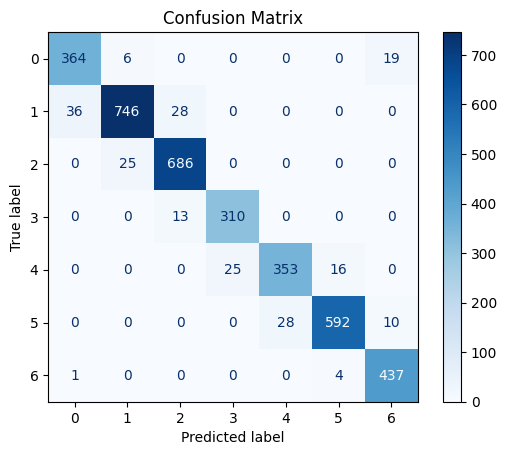

In [44]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn_bilstm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Calculate accuracy for each label
label_accuracy = {}
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # Recall in this context is TP / (TP + FN)
        label_accuracy[label] = accuracy

# Print accuracy for each label
for label, accuracy in label_accuracy.items():
    print(f"Accuracy for label {label}: {accuracy:.3f}")

Accuracy for label A: 0.936
Accuracy for label B: 0.921
Accuracy for label C: 0.965
Accuracy for label D: 0.960
Accuracy for label E: 0.896
Accuracy for label F: 0.940
Accuracy for label G: 0.989


In [55]:
# Save the model architecture and weights to a file
model_cnn_bilstm.save('model_cnn_bilstm_LS.h5')

# Save additional objects (e.g., training history, additional settings) using pickle
pkl_history_cnn_bilstm = history_cnn_bilstm.history  # Assuming you have the history from training
with open('history_cnn_bilstm.pkl', 'wb') as f:
    pickle.dump(pkl_history_cnn_bilstm, f)